Processing grayscale image...


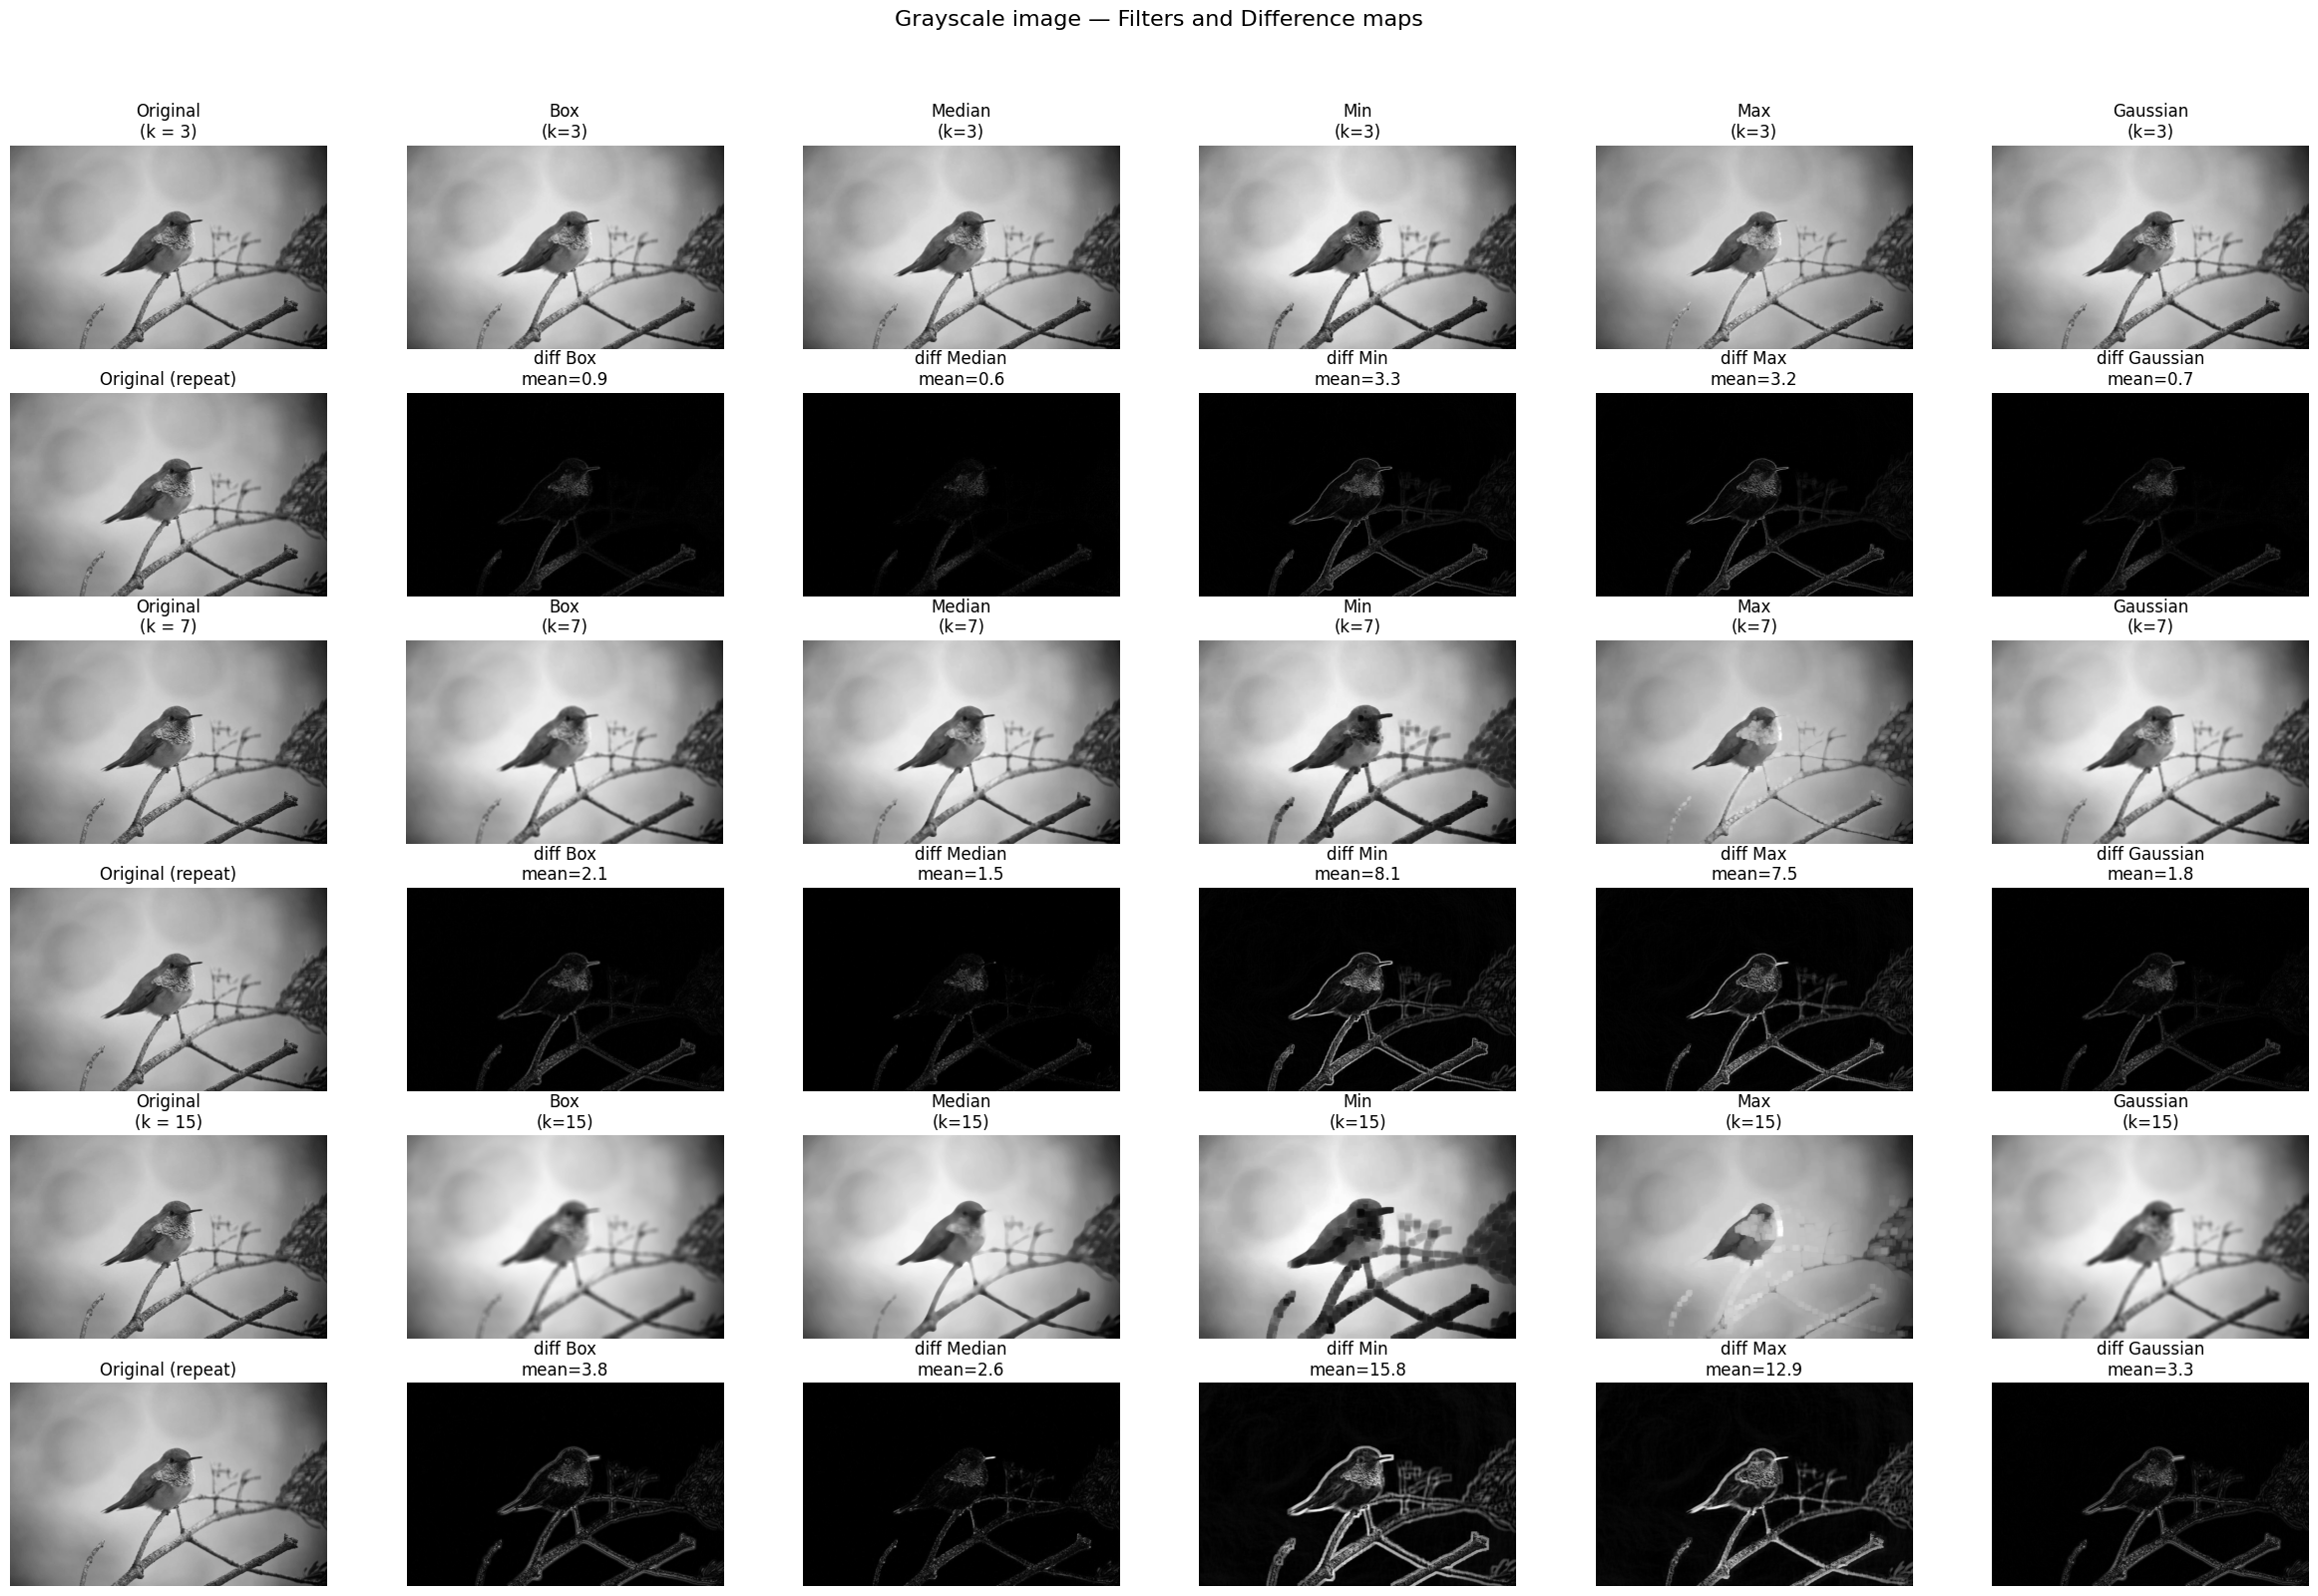

Processing color image...


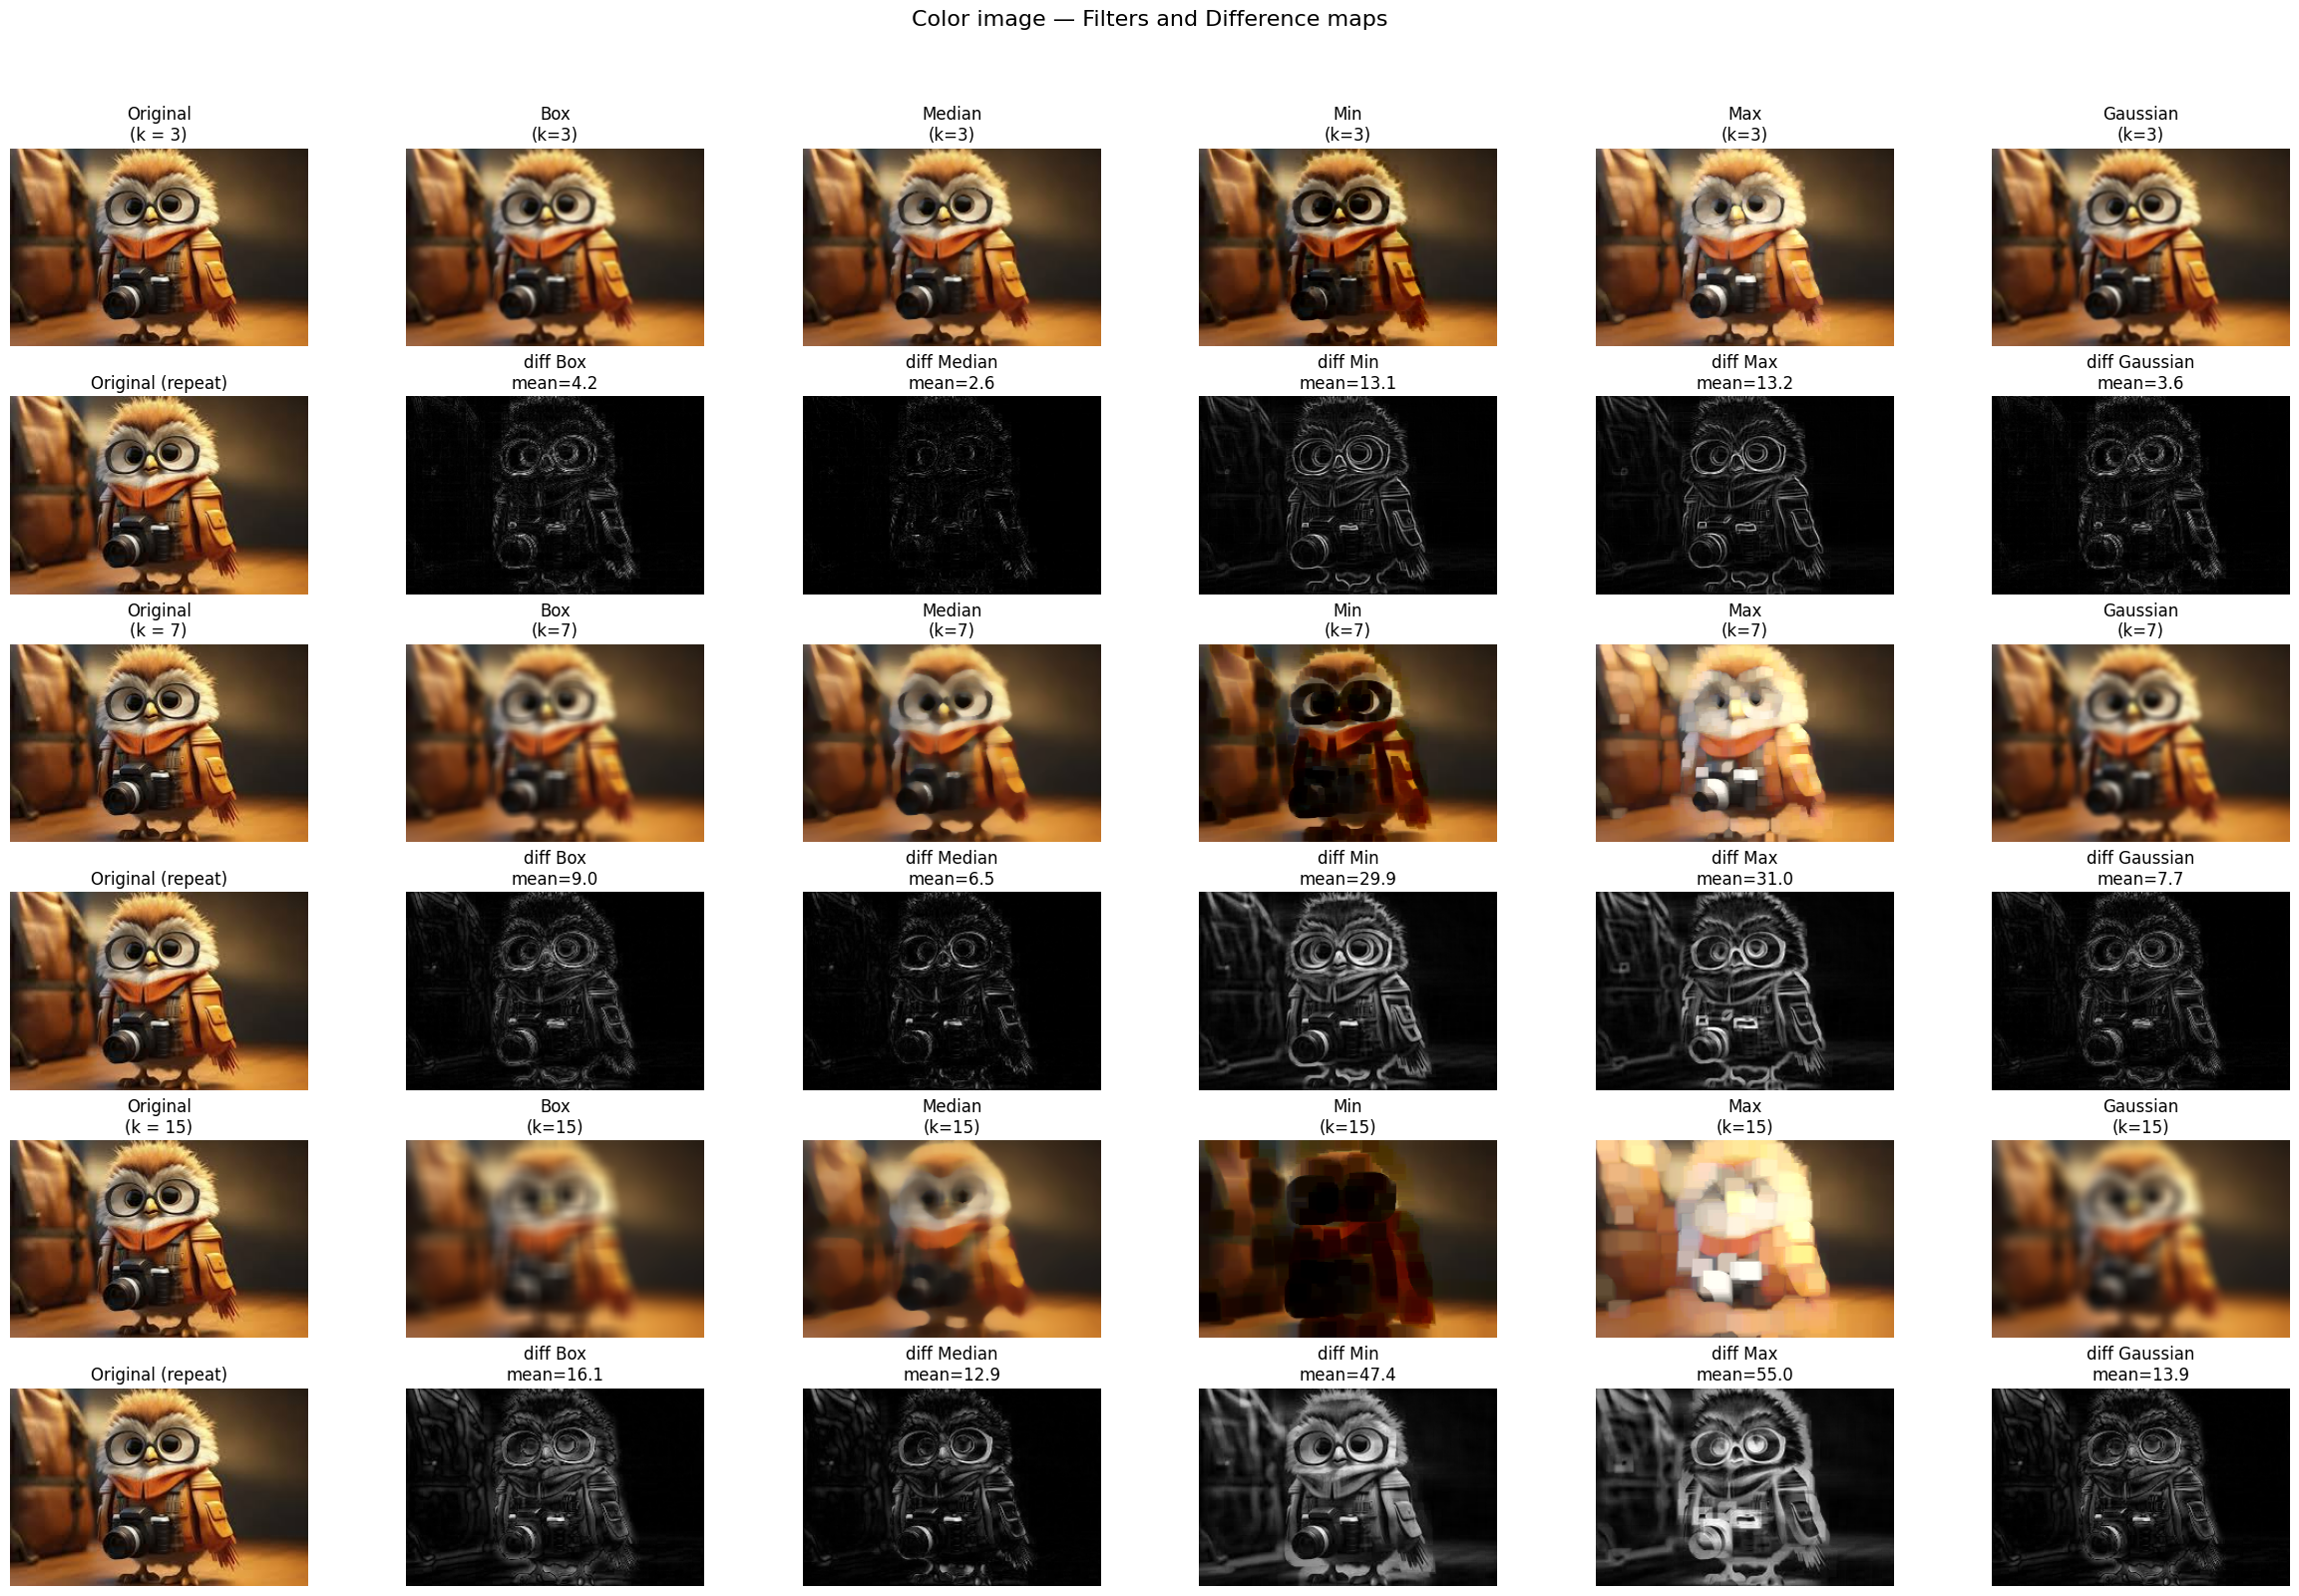

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# ---------------------------
# Configuration - change paths here
color_path = "image.png"
gray_path  = "Grayscale_Image.jpg"  # optional; if missing, grayscale will be derived from color
kernel_sizes = [3, 7, 15]  # try 3,7,15 to make differences more visible
# ---------------------------

def read_images(color_p, gray_p=None):
    color = cv2.imread(color_p, cv2.IMREAD_COLOR)
    if color is None:
        raise FileNotFoundError(f"Color image not found: {color_p}")
    if gray_p:
        gray = cv2.imread(gray_p, cv2.IMREAD_GRAYSCALE)
    else:
        gray = None
    if gray is None:
        gray = cv2.cvtColor(color, cv2.COLOR_BGR2GRAY)
    return color, gray

def apply_filters(img, k):
    """Apply the requested filters. img may be grayscale or BGR color."""
    # Ensure k is odd for median / gaussian kernel size
    if k % 2 == 0:
        k = k + 1

    # Box (averaging)
    box = cv2.blur(img, (k, k))

    # Median (works on single or multi-channel with OpenCV)
    # medianBlur only accepts single or 3-channel images and odd k
    median = cv2.medianBlur(img, k)

    # Min (erosion) and Max (dilation)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k, k))
    minf = cv2.erode(img, kernel)
    maxf = cv2.dilate(img, kernel)

    # Gaussian - pick sigma proportional to kernel to exaggerate difference
    sigma = max(0.1, k / 3.0)
    gaussian = cv2.GaussianBlur(img, (k, k), sigmaX=sigma, sigmaY=sigma)

    return {
        "Box": box,
        "Median": median,
        "Min": minf,
        "Max": maxf,
        "Gaussian": gaussian
    }

def normalize_for_display(img):
    """Normalize image to 0-255 uint8 for display (single or multi-channel)."""
    img_out = img.astype(np.float32)
    mn, mx = img_out.min(), img_out.max()
    if mx - mn < 1e-6:
        return np.zeros_like(img, dtype=np.uint8)
    img_out = (img_out - mn) / (mx - mn) * 255.0
    return img_out.astype(np.uint8)

def absdiff_gray(orig, filtered):
    """Return grayscale absolute difference between orig and filtered, normalized."""
    # if color, convert to BGR np arrays; absdiff works with same shapes
    diff = cv2.absdiff(orig, filtered)
    # If color (3 channels), convert to gray for difference magnitude display
    if diff.ndim == 3 and diff.shape[2] == 3:
        diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    else:
        diff_gray = diff
    diff_norm = normalize_for_display(diff_gray)
    return diff_norm, float(diff_gray.mean())

def plot_results(original, results_by_k, title="Image"):
    """Grid: for each kernel size: 1st row original+filters, 2nd row diffs"""
    filters = ["Box", "Median", "Min", "Max", "Gaussian"]
    cols = 1 + len(filters)  # Original + each filter
    rows = len(results_by_k) * 2
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 2.8 * rows))
    fig.suptitle(f"{title} — Filters and Difference maps", fontsize=16)

    # Ensure axes is 2D array
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)
    if cols == 1:
        axes = np.expand_dims(axes, axis=1)

    for i, (k, res) in enumerate(results_by_k.items()):
        row_orig = 2 * i
        row_diff = row_orig + 1

        # Column 0: Original (only show once per kernel row)
        # Display color as RGB, grayscale with cmap
        orig_to_show = original
        is_color = (original.ndim == 3 and original.shape[2] == 3)
        if is_color:
            orig_plot = cv2.cvtColor(orig_to_show, cv2.COLOR_BGR2RGB)
            axes[row_orig, 0].imshow(orig_plot)
        else:
            axes[row_orig, 0].imshow(orig_to_show, cmap='gray')
        axes[row_orig, 0].set_title(f"Original\n(k = {k})")
        axes[row_orig, 0].axis('off')

        # For the diff row under original, show a blank or the normalized original (just to keep grid neat)
        if is_color:
            axes[row_diff, 0].imshow(orig_plot)
        else:
            axes[row_diff, 0].imshow(orig_to_show, cmap='gray')
        axes[row_diff, 0].set_title("Original (repeat)")
        axes[row_diff, 0].axis('off')

        # Columns 1.. = each filter and its diff
        for j, fname in enumerate(filters, start=1):
            fimg = res[fname]

            # Show filtered result
            if is_color:
                axes[row_orig, j].imshow(cv2.cvtColor(fimg, cv2.COLOR_BGR2RGB))
            else:
                axes[row_orig, j].imshow(fimg, cmap='gray')
            axes[row_orig, j].set_title(f"{fname}\n(k={k})")
            axes[row_orig, j].axis('off')

            # Show normalized absolute difference below
            diff_img, mean_diff = absdiff_gray(original, fimg)
            axes[row_diff, j].imshow(diff_img, cmap='gray')
            axes[row_diff, j].set_title(f"diff {fname}\nmean={mean_diff:.1f}")
            axes[row_diff, j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def main():
    color, gray = read_images(color_path, gray_path if os.path.exists(gray_path) else None)

    # --- Process grayscale ---
    print("Processing grayscale image...")
    gray_results_by_k = {}
    for k in kernel_sizes:
        gray_results_by_k[k] = apply_filters(gray, k)
    plot_results(gray, gray_results_by_k, title="Grayscale image")

    # --- Process color ---
    print("Processing color image...")
    color_results_by_k = {}
    for k in kernel_sizes:
        color_results_by_k[k] = apply_filters(color, k)
    plot_results(color, color_results_by_k, title="Color image")

if __name__ == "__main__":
    main()
